In [1]:
import pymc3 as pm
from pymc3.gp.cov import *
import numpy as np
from chromatic_fitting import *
import arviz as az
import pymc3_ext as pmx

Running chromatic_fitting v0.9.8!

This program is running on:
Python v3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy v1.21.6
chromatic v0.4.5
pymc3 v3.11.4
pymc3_ext v0.1.1
exoplanet v0.5.3


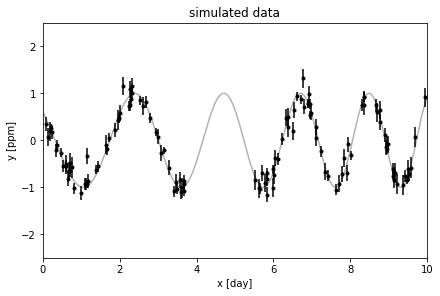

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 57),
        np.random.uniform(5.5, 10, 68),
    )
)#[:, None] # The input coordinates must be sorted

yerr = np.random.uniform(0.08, 0.22, len(t))
# y = (
#     0.2 * (t - 5)
y = (np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t)))


true_t = np.linspace(0, 10, 500)
# true_y = 0.2 * (true_t - 5) + 
true_y = np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

In [49]:
with pm.Model() as model:
    # Specify the covariance function.
    ls = pm.Normal('ls',mu=0.1, sigma=3)
    period = pm.Normal('period',mu=2, sigma=2)
    cov_func = pm.gp.cov.Periodic(input_dim=1, period=period, ls=ls)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func, mean_func=pm.gp.mean.Zero())

    # Place a GP prior over the function f.
    sigma = pm.HalfCauchy("sigma", beta=3)
    y_ = gp.marginal_likelihood("y", X=t[:,None], y=y, noise=sigma)
    
    mp = pm.find_MAP()
#     f_pred = gp.conditional("f_pred", true_t[:,None])
#     y_obs = pm.gp.gp('y_obs', cov_func=cov_func,mean_func=pm.gp.mean.Zero(), sigma=sigma, observed={'X':t[:,None], 'Y':y})
    opt = pmx.optimize()
    trace = pm.sample(start=opt, tune=1000,draws=1000, chains=2, cores=2, init = "adapt_full")

# After fitting or sampling, specify the distribution
# at new points with .conditional
# Xnew = np.linspace(-1, 2, 50)[:, None]

# with model:
#     f_cond = gp.conditional("fcond", Xnew=true_t[:,None])
#     y_cond = gp.conditional("ycond", Xnew=true_t[:,None],pred_noise=True)
#     trace = pm.sample()
#     mp = pm.find_MAP()

optimizing logp for variables: [sigma, period, ls]


message: Optimization terminated successfully.
logp: -264.46970270125985 -> -93.47103528964549
/var/folders/6k/5j78gjkn74b4xb382c27jzwr0000gn/T/ipykernel_61412/3268711326.py:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(start=opt, tune=1000,draws=1000, chains=2, cores=2, init = "adapt_full")
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...


/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, period, ls]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 41 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [50]:
az.__version__

'0.14.0'

In [51]:
with model:
    summary = az.summary(trace)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ls,1.112,0.358,0.496,1.786,0.009,0.007,1580.0,1319.0,1.0
period,2.140,0.021,2.101,2.181,0.000,0.000,1839.0,1394.0,1.0
sigma,0.464,0.031,0.409,0.525,0.001,0.000,2131.0,1320.0,1.0


In [52]:
# check Rhat, values above 1 may indicate convergence issues
n_nonconverged = int(np.sum(az.rhat(trace)[["ls", "period", "sigma"]].to_array() > 1.03).values)
print("%i variables MCMC chains appear not to have converged." % n_nonconverged)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/catrionamurray/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


0 variables MCMC chains appear not to have converged.


In [53]:
mp

{'ls': array(0.9828265),
 'period': array(2.14095147),
 'sigma_log__': array(-0.7879012),
 'sigma': array(0.45479833)}

In [26]:
# The mean and full covariance
# mu, cov = gp.predict(true_t[:,None], point=trace[-1])

# # The mean and variance (diagonal of the covariance)
# mu, var = gp.predict(true_t[:,None], point=trace[-1],  diag=True)

# # With noise included
mu, var = gp.predict(true_t[:,None], point=trace[-1],  diag=True, pred_noise=True)

In [54]:
# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", true_t[:,None])
    mp = pm.find_MAP()

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], samples=2000)

In [55]:
pred_samples.keys()

dict_keys(['y'])

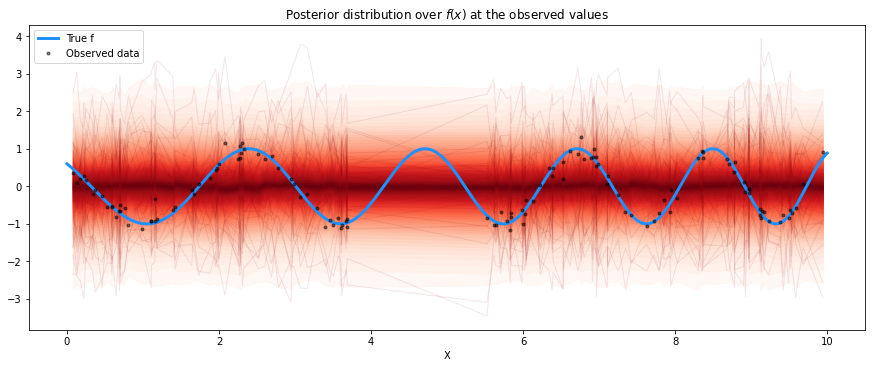

In [59]:
# plot the results
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

# plot_gp_dist(ax, pred_samples["f_pred"], true_t)
plot_gp_dist(ax, pred_samples["y"], t)

# plot the data and the true latent function
plt.plot(true_t, true_y, "dodgerblue", lw=3, label="True f")
plt.plot(t, y, "ok", ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X")
# plt.ylim([-13, 13])
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

In [ ]:
# predict
mu, var = gp.predict(true_t, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(true_t, mu, "r", lw=2, label="mean and 2σ region")
plt.plot(true_t, mu + 2 * sd, "r", lw=1)
plt.plot(true_t, mu - 2 * sd, "r", lw=1)
plt.fill_between(true_t.flatten(), mu - 2 * sd, mu + 2 * sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(t, y, "ok", ms=3, alpha=1.0, label="observed data")
plt.plot(true_t, true_y, "dodgerblue", lw=3, label="true f")

plt.xlabel("x")
# plt.ylim([-13, 13])
plt.title("predictive mean and 2σ interval")
plt.legend();

In [6]:
# # set up polynomial model:
# gp = GPModel(kernel=ExpQuad(1, ls=0.1))

# gp.setup_parameters(
#      = WavelikeFitted(Uniform,testval=0.01,upper=2,lower=-2),
# )

# # print a summary of all params:
# p.summarize_parameters()

ModuleNotFoundError: No module named 'pm'

In [ ]:

# GP('y_obs', cov_func=f_cov, sigma=s2_n, observed={'X':X, 'Y':y})